<a href="https://colab.research.google.com/github/arsb29/web-scraping/blob/main/tag-cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import nltk
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_ru')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!


True

Парсер ланных статьи с хабра по id статьи

In [3]:
def get_article_info(id):
  link = f'https://habr.com/ru/post/{id}/'
  articleData = requests.get(link)

  if articleData.status_code == 200:
    bs = BeautifulSoup(articleData.text, 'html.parser')
    author = bs.find('a', {'class': 'tm-user-info__userpic'})
    datetime = bs.find('span', {'class': 'tm-article-snippet__datetime-published'}).time['datetime']
    title = bs.find('h1', {'class': 'tm-article-snippet__title'}).get_text()
    text = bs.find('div', {'class': 'tm-article-body'}).get_text()
    tags = [li.text for li in bs.find_all('li', {'class': 'tm-separated-list__item'})]

    article_result = {
      'title': title,
      'datetime': datetime,
      'link': link,
      'text': text,
      'tags': tags
    }

    if author:
      article_result['author'] = author['title']
  
    return article_result
  return None

In [4]:
def habr_parse(query, pages):
  results = {'query': query, 'articles': []}
  pages_range = [str(i) for i in range(1, pages + 1)]
  
  for page in pages_range:
    data = requests.get(f'https://habr.com/ru/search/page{page}/?q={query}')
    if data.status_code == 200:
      bs = BeautifulSoup(data.text, 'html.parser')
      articles = bs.find_all('article', {'class': 'tm-articles-list__item'})
      for article in articles:
        article_info = get_article_info(article['id'])
        if article_info:
          results['articles'].append(article_info)

  return results

In [5]:
QUERY = 'криптография'
PAGES = 2

In [6]:
result = habr_parse(QUERY, PAGES)

In [7]:
all_articles = ". ".join([article['text'] for article in result['articles']])

Построение «облака тегов»

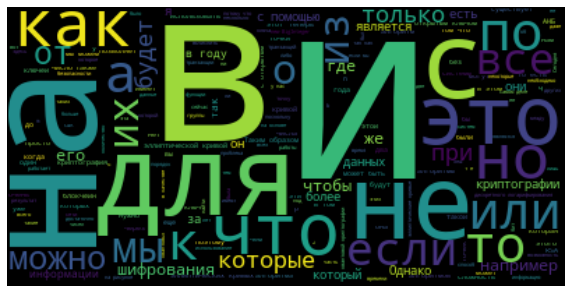

In [8]:
wordcloud = WordCloud().generate(all_articles)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Самые популярные слова - предлоги, местоимения, частицы. Они не несут в себе смысловой нагрузки, поэтому убираю их

In [9]:
words = nltk.word_tokenize(all_articles)
functors_pos = {'PR', 'NONLEX', 'CONJ', 'PART', 'A-PRO=f', 'A-PRO=pl', 'S-PRO', 'S-PRO=dat', 'ADV-PRO', 'A-PRO=m', 'PRAEDIC'}
pure_all_articles = ' '.join([word for word, pos in nltk.pos_tag(words, lang='rus') if pos not in functors_pos])

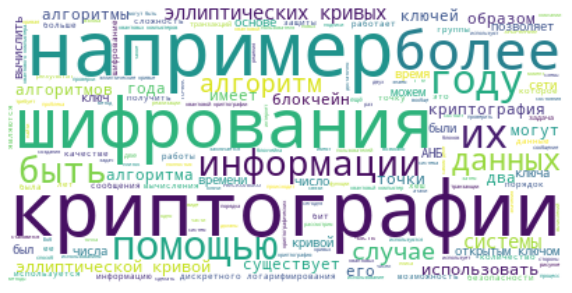

In [10]:
wordcloud = WordCloud(
    stopwords = ['есть', 'уже', 'также', 'будет', 'еще', 'будут', 'было', 'можете', 'очень', 'может', 'является'],
    background_color = 'white'
).generate(pure_all_articles)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()